Why am I getting qualitatively different results from different types of draws?

In [1]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [2]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns


Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium.300',
             'mpi-esm-p_last_millenium.300',
             'hadcm3_last_millenium.300']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 300 ensemble members
regridding prior...
0 55295
(55296, 300)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -10.309103965759277 8.361244201660156 0.0006951936449991374 0.837488286199055
=> Truncated array: -10.161219839628949 

In [5]:
# Plot zonal means

def plt_zonal(cdd4,lat):

    key = np.array([[0,3,6],[1,4,7],[2,5,8]])

    # identify which is the truth-truth pair in each
    ttkey = np.array([0,1,2])

    colkey = ['r','c','y']

    rr = np.empty(2)

    for ii in np.arange(3):
        fig = plt.figure(figsize=(4,2.))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,0]]['tind']]['Xbp'],1).reshape([91,180]),1),'r',linewidth=2)
        plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,1]]['tind']]['Xbp'],1).reshape([91,180]),1),'c',linewidth=2)
        plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,2]]['tind']]['Xbp'],1).reshape([91,180]),1),'y',linewidth=2)
        plt.ylabel('Zonal mean error variance\nfraction (normalized)')
        plt.ylim([0,2.0])
        plt.xlim([-80,80])
        plt.xlabel('Latitude')

        lgd = plt.legend([cdd4[key[ii,0]]['prior_name'],
                    cdd4[key[ii,1]]['prior_name'],
                    cdd4[key[ii,2]]['prior_name']],
                    bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
        plt.xticks([-60,-30,0,30,60])
        ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
        plt.show();

        not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]

        ttr  = np.mean(cdd4[key[ii,ttkey[ii]]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,ttkey[ii]]]['tind']]['Xbp'],1).reshape([91,180]),1)
        rr0  = np.mean(cdd4[key[ii,not_tt[0]]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,not_tt[0]]]['tind']]['Xbp'],1).reshape([91,180]),1)
        rr1  = np.mean(cdd4[key[ii,not_tt[1]]]['rmse'].reshape([91,180])**2/
                 np.var(ad[cdd4[key[ii,not_tt[1]]]['tind']]['Xbp'],1).reshape([91,180]),1)

        fig = plt.figure(figsize=(4,1.5))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        plt.plot(lat,(rr0-ttr)/rr0,colkey[not_tt[0]],linewidth=2)
        plt.plot(lat,(rr1-ttr)/rr1,colkey[not_tt[1]],linewidth=2)

        plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
        plt.ylim([0,0.6])
        plt.xlim([-80,80])
        plt.xlabel('Latitude')
        plt.xticks([-60,-30,0,30,60])
        ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
        plt.show();



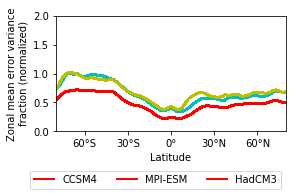

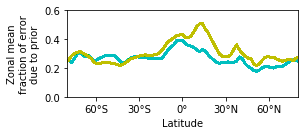

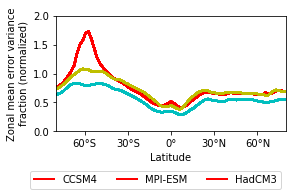

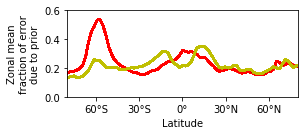

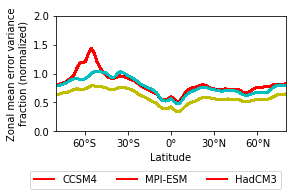

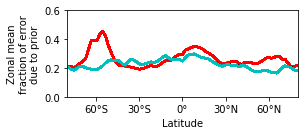

In [8]:
# Load

SNR  = 0.4
lat = ad[0]['grid'].lat

cdd4 = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0'+ '_snr_' + str(SNR)+'_300_redo_for_ad.npy')
plt_zonal(cdd4,lat)

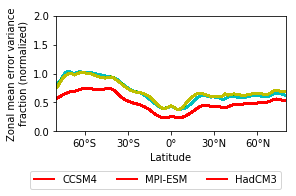

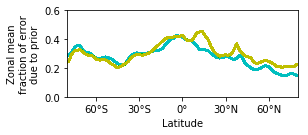

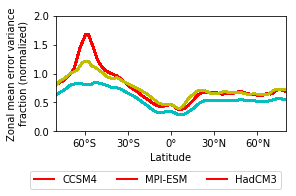

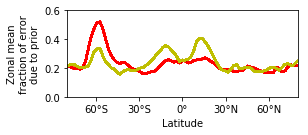

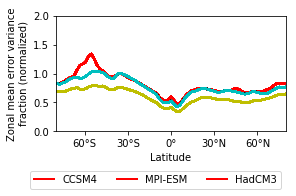

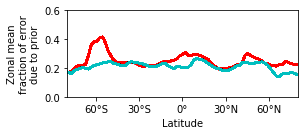

In [9]:
cdd4  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+str(SNR)+'_300'+'.npy')
plt_zonal(cdd4,lat)

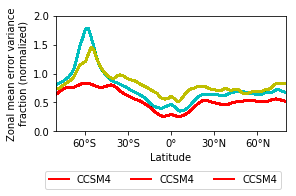

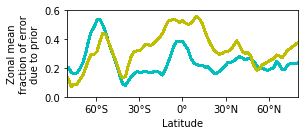

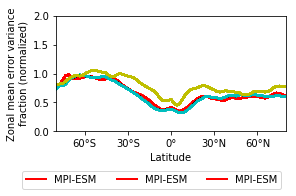

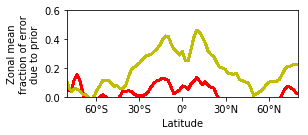

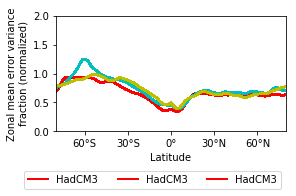

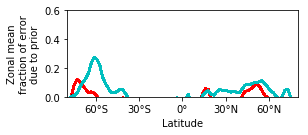

In [10]:
cdd4  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
plt_zonal(cdd4,lat)

Qualitatively different results when looking at the random draws. Why? Is this the effect of not having perfect priors? But see results from the sensitivity tests notebook showing that even random draws from the right prior are consistently better than from other priors. Are these results limited to CCSM4 (truth model in that notebook)? I could test by running those experiments with others as truth. (Another question: if perfect priors are important for a substantial difference between right and wrong model, why 

In [31]:
#LOCRAD=10000

# Goal: For each model truth, plot global mean RMSE 
import pandas as pd
SNR = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR+'_300' + '.npy')

    for jj in np.arange(len(cdd4)):

        # Skip same p-t cases and replace with random draws in next cell
        if cdd4[jj]['prior_name']==cdd4[jj]['truth_name']:
            continue
 
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]

        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




In [32]:
# Grab same p-t cases from random draws

# Goal: For each model truth, plot global mean RMSE 
import pandas as pd
SNR = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad[0]['grid'].lat

#gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])

for ii,LOCRAD in enumerate(LOCRADs):

    
    #cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_locrad_' + LOCRAD + '.npy')
    cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_locrad_' + LOCRAD+'_300_redo_for_ad.npy')
    for jj in np.arange(len(cdd4)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




FileNotFoundError: [Errno 2] No such file or directory: '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_locrad_0.0_300_redo_for_ad.npy'

In [ ]:
sns.set(style='ticks', context='talk')

si = 15
fig = plt.figure(figsize=(8,6))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
#plt.ylim([0.2,0.42])
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.01, .92), loc=2, borderaxespad=0.,frameon=True)
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')


In [29]:
# Sanity check with LOCRAD = 0.0

# Goal: For each model truth, plot global mean RMSE 
import pandas as pd
SNR = '0.4'
LOCRADs = ['0.0']
lat = ad[0]['grid'].lat

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])

for ii,LOCRAD in enumerate(LOCRADs):

    
    cdd4 = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0'+ '_snr_' + str(SNR)+'_300_redo_for_ad.npy')


    for jj in np.arange(len(cdd4)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

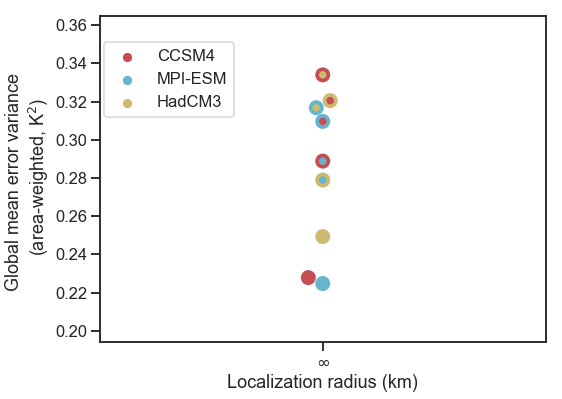

In [30]:
sns.set(style='ticks', context='talk')

si = 15
fig = plt.figure(figsize=(8,6))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
#plt.ylim([0.2,0.42])
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.01, .92), loc=2, borderaxespad=0.,frameon=True)
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')


Make the gumball / localization plot but now with imperfect (random no replacement) draws of CCSM4.

In [ ]:
SNR     = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat     = ad[0]['grid'].lat


gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    # Load the standard case with perfect "diagonal" draws
    cdd4  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR+'_300' + '.npy')
    for jj in np.arange(len(cdd4)):
      
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)

    # Load the imperfect draw case
    cdd1  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_locrad_' + LOCRAD+ '.npy')
    for jj in np.arange(len(cdd1)):
      
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd1[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd1[jj]['prior_name']+'_RD',
                            "truth_name":cdd1[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




In [ ]:
sns.set(style='ticks', context='talk')

si = 15
fig = plt.figure(figsize=(8,4))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.67, .47), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')


Compute regional means

In [ ]:
# Regional means

# Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
# Arctic: >60
# Antarctic: >60
# N America: 30-55 N, 135-75 W
# S America: 66-20 S, 82-37 W
# Europe: 37 - 70 N, 7W - 40 E
# Asia: 23-47 N, 60-165E
# Australasia: 50-0S, 120-180 E

SNR = 0.4
LOCRAD = 0.0

# New runs that save the truth cases...
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'_300_redo_for_ad.npy')
ad = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'_300_redo_for_ad_ad.npy')

# Now for random draws
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'.npy')
#Xbpt_dd  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'_ad.npy')

lats = ad[0]['grid'].lat
lons = ad[0]['grid'].lon
nlat = ad[0]['grid'].nlat
nlon = ad[0]['grid'].nlon
Inf = np.inf

# Mins and maxes defined looking from left to right on the globe
regnames = ['NH','SH','Arctic', 'Antarctic','N. America','S. America','Europe','Asia','Australasia']
reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50]
reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0]
reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120]
reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180]

#regnames = ['NH']
#reglatmins = [0]
#reglatmaxs = [Inf]
#reglonmins = [-Inf]
#reglonmaxs = [Inf]

wtmaps = np.tile(np.nan*np.ones([nlat,nlon]),[len(regnames),1,1])
allmap_std_ps = np.nan*np.ones([nlat,nlon])

std_ps = np.nan*np.ones([len(cdd),len(regnames)])

gmp = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

counter = 0

for jj in np.arange(len(regnames)):
    for ii in np.arange(len(cdd)):
        
        # Replace same p-t cases with random draws
        if cdd[ii]['prior_name']==cdd[ii]['truth_name']:
            continue
        
        ti    = cdd[ii]['tind']
        fp    = cdd[ii]['recon']
        
        # Define the region
        wtmap = np.nan*np.ones([nlat,nlon])
        
        if reglonmins[jj]>reglonmaxs[jj]:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
        else:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])
        lwm = np.cos(.5*np.pi*lats[sh]/180)
        #wt1 =  lwm/np.sum(lwm)
        wt1 = lwm
        # wtmap[sh] = wt1[:]
        # wtmaps[jj,:,:] = wtmap*0+1;

        # Straight "truth" estimate:
        m_st = np.dot(wt1.T/np.sum(wt1),ad[ti]['Xbp'][sh.ravel(),:])
        #m_st = np.dot(wt1.T/np.sum(wt1),ad[ti]['Xbp'][sh.ravel(),:])

        # Straight "prior" estimate:
        m_sp = np.dot(wt1.T/np.sum(wt1),fp[sh.ravel(),:])
        
        

        nee = pd.DataFrame({"errvar":[np.var(m_sp-m_st)],
                    "wtd_errvar":[np.var(m_sp-m_st)/np.var(m_st)],
                    "region":regnames[jj],
                    "prior_name":cdd[ii]['prior_name'],
                    "truth_name":cdd[ii]['truth_name'],
                    "regind":jj
                   })
        gmp=gmp.append(nee)
                                                        

In [ ]:
# Add regional means for the random draws case. Bit of a kludge.

# Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
# Arctic: >60
# Antarctic: >60
# N America: 30-55 N, 135-75 W
# S America: 66-20 S, 82-37 W
# Europe: 37 - 70 N, 7W - 40 E
# Asia: 23-47 N, 60-165E
# Australasia: 50-0S, 120-180 E

SNR = 0.4
LOCRAD = 0.0

# New runs that save the truth cases...
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'_300_redo_for_ad.npy')
#ad = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'_300_redo_for_ad_ad.npy')

# Now for random draws
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'.npy')
Xbpt_dd  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'_ad.npy')

lats = ad[0]['grid'].lat
lons = ad[0]['grid'].lon
nlat = ad[0]['grid'].nlat
nlon = ad[0]['grid'].nlon
Inf = np.inf

# Mins and maxes defined looking from left to right on the globe
regnames = ['NH','SH','Arctic', 'Antarctic','N. America','S. America','Europe','Asia','Australasia']
reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50]
reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0]
reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120]
reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180]

#regnames = ['NH']
#reglatmins = [0]
#reglatmaxs = [Inf]
#reglonmins = [-Inf]
#reglonmaxs = [Inf]

wtmaps = np.tile(np.nan*np.ones([nlat,nlon]),[len(regnames),1,1])
allmap_std_ps = np.nan*np.ones([nlat,nlon])

std_ps = np.nan*np.ones([len(cdd),len(regnames)])

gmp = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

counter = 0

for jj in np.arange(len(regnames)):
    for ii in np.arange(len(cdd)):
        
        fp    = cdd[ii]['recon']
        
        # Define the region
        wtmap = np.nan*np.ones([nlat,nlon])
        
        if reglonmins[jj]>reglonmaxs[jj]:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
        else:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])
        lwm = np.cos(.5*np.pi*lats[sh]/180)
        wt1 = lwm

        # Straight "truth" estimate:
        m_st = np.dot(wt1.T/np.sum(wt1),Xbpt_dd[ii,:,:][sh.ravel(),:])

        # Straight "prior" estimate:
        m_sp = np.dot(wt1.T/np.sum(wt1),fp[sh.ravel(),:])

        nee = pd.DataFrame({"errvar":[np.var(m_sp-m_st)],
                    "wtd_errvar":[np.var(m_sp-m_st)/np.var(m_st)],
                    "region":regnames[jj],
                    "prior_name":cdd[ii]['prior_name'],
                    "truth_name":cdd[ii]['truth_name'],
                    "regind":jj
                   })
        gmp=gmp.append(nee)
                                                        

In [ ]:
sns.set(style='ticks', context='talk')

si = 15
fig = plt.figure(figsize=(14,8))
sns.swarmplot(data=gmp,x="regind", y="wtd_errvar", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="regind", y="wtd_errvar", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(regnames)),regnames,rotation=45,ha="right")
#ax.set_xticklabels(rotation=45 )
plt.xlabel('')
plt.ylabel('Error variance of global, hemispheric, \n and spatial means (K$^2$)')

handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.05, .75), loc=3, borderaxespad=0.,frameon=True)
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')